<img width="1500" style="float:center;" src="figures/Heading1_ipynb.png" />

<h1><font size="6" face="arial" color="#609BC4">Context</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">A current topic in system neuroscience literature is the presence of brain activity in the absence of a task condition. These task-negative, spontaneous fluctuations occur in the so-called <b>rest state</b>, and a recurring theme of these fluctuations is that they have a network structure. Because TVB uses the structural connectivity of the brain as the backbone for simulating spontaneous activity, resting-state activity and its network structure is a prime candidate for modeling in TVB.</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Objectives</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">In this mini-project, we will:
<br>
<ul>
    <li>Build a brain network model using subject-specific structural connectivity,</li> 
    <li>Simulate resting-state activity,</li>
    <li>Characterize the resting-state activity by calculating the functional connectivity (FC),</li>
    <li>Extract the resting-state networks (RSNs).</li>
</ul></font></div></p>

<h1><font size="6" face="arial" color="#609BC4">How to do it with TVB?</font></h1> 

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">In the first part of this tutorial, we presents the basic anatomy of a region simulation using The Virtual Brain's scripting interface.</font></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we want to do is to import the modules we will need for a simulation.</font></div></p>

In [1]:
%pylab nbagg

# Import a bunch of stuff to ease command line usage
from tvb.simulator.lab import *
# FC 
from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.correlation_coefficient as corr_coeff
# Phase Plane
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
# ICA
import scipy.stats
from sklearn.decomposition import FastICA
# brain maps
import utils

import numpy as np
import time as tm
import matplotlib.pyplot as plt        
import matplotlib.gridspec as gridspec 

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


<h1><font size="6" face="arial" color="black">1. Setting up the simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A basic simulation of TVB consists of <b>5 main components</b>. Each of these components is an object within TVB:</font>

- ## <font size="5"face="arial" color="black"> Connectivity</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We start by loading and visualizing the structural connectivity matrix that represents the set of all existing connections between brain areas. Having loaded the default dataset, we can then alter the speed of signal propagation through the network:</font></div></p>

WARNING  File 'hemispheres' not found in ZIP.


<IPython.core.display.Javascript object>


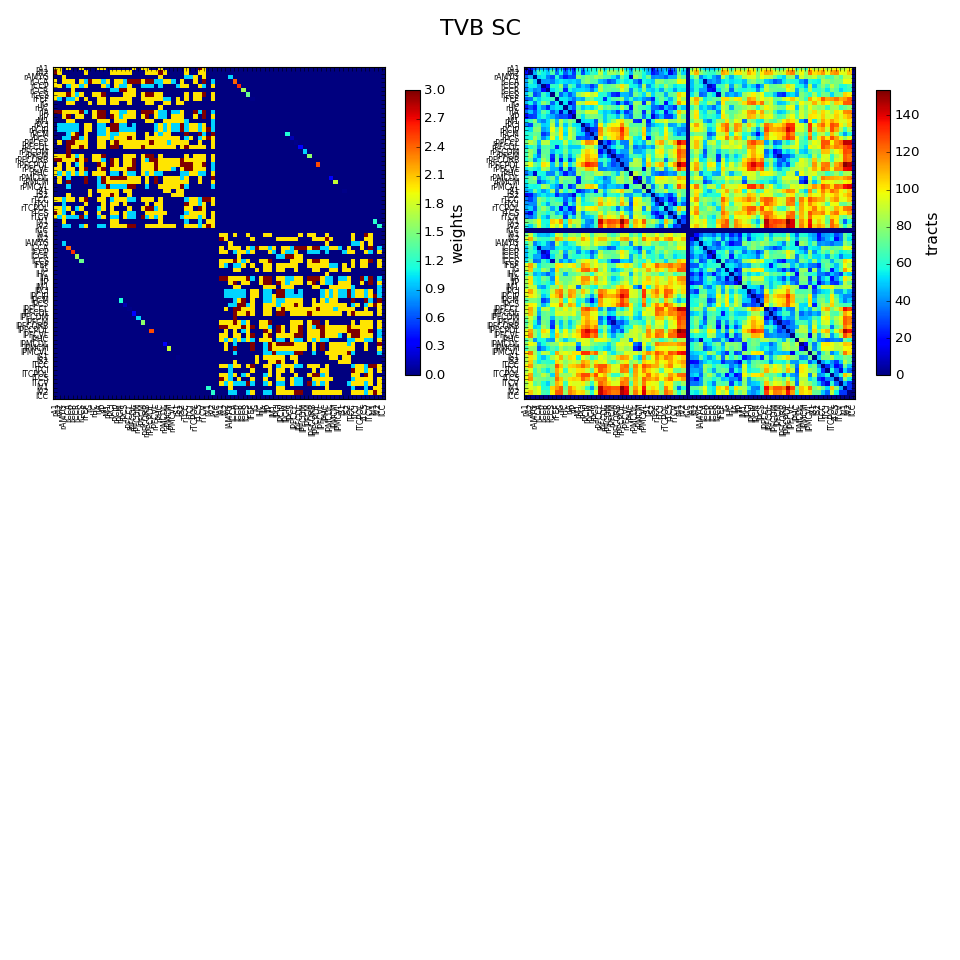

In [2]:
# Import the anatomical structural connectivity.
TVB_con = connectivity.Connectivity(load_default=True)      
nregions = len(TVB_con.region_labels)     #number of regions
TVB_con.speed = np.inf                    #set the conduction speed
TVB_con.configure()

TVB_SC = TVB_con.weights

# Visualization
fig=plt.figure(figsize=(12,12))
fig.suptitle('TVB SC', fontsize=20)

# weights
plt.subplot(121)
plt.imshow(TVB_con.weights, interpolation='nearest', aspect='equal', cmap='jet')
plt.xticks(range(0, nregions), TVB_con.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), TVB_con.region_labels, fontsize=7)
cb=plt.colorbar(shrink=0.2)
cb.set_label('weights', fontsize=14)

#tracts
plt.subplot(122)
plt.imshow(TVB_con.tract_lengths, interpolation='nearest', aspect='equal', cmap='jet')
plt.xticks(range(0, nregions), TVB_con.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), TVB_con.region_labels, fontsize=7)
cb=plt.colorbar(shrink=0.2)
cb.set_label('tracts', fontsize=14)

fig.tight_layout()
fig.subplots_adjust(top=1.5)

plt.show()

- ## <font size="5" face="arial" color="black"> Model</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A set of differential equations describing the local neural dynamics. There are a number of predefined models available in TVB, as an example here we will use the <b>Generic 2-dimensional Oscillator</b> model:</font></div></p>

In [3]:
# Initialise a Model.
g2d = models.Generic2dOscillator(a=1.7402)
g2d

Generic2dOscillator(bound=False, value=None)

- ## <font size="5"face="arial" color="black">Coupling function</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">It is a function that is used to join the local <b>Model</b> dynamics at distinct spatial locations over the connections described in <b>Connectivity</b>. Proper setting of the parameters for this function requires some knowledge of the properties of both the model being used and the structure through which it is connected. For our present purposes, we happen to know that for this configuration of parameters of TVB's <b>Generic2dOscillator</b> connected through TVB's default connectivity matrix, a linear function with a slope of 0.0075 is a reasonable thing to use.</font></div></p>

In [4]:
# Initialise a Coupling function.
G = 0.0075                       
con_coupling = coupling.Scaling(a=G)

- ## <font size="5"face="arial" color="black">Integrator</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Now that we have defined our structure and dynamics, we need to select an integration scheme. While TVB supports a number of schemes, for most purposes you should use either <b>HeunDeterministic</b> or <b>HeunStochastic</b></font></div></p> 

<p><div style="text-align: justify"><font size="4.5" face="time roman">Note that the most important thing here is to use a step size that is small enough for the integration to be numerically stable.</font></div></p>


In [5]:
# Initialise an Integrator scheme.
dt = 0.1               #integration steps [ms]

#heunint = integrators.HeunDeterministic(dt=dt)

nsigma = 0.001         #standard deviation of the noise
hiss = noise.Additive(nsig=np.array([nsigma, 0]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

- ## <font size="5"face="arial" color="black">Monitors</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The last component we need to define are some Monitors. Although there are Monitors which apply a biophysical measurement process to the simulated neural activity, such as EEG, MEG, etc, here we will select two simple monitors just to show the idea:
<pre></pre>

<ul>
<li>the <b>Raw</b> monitor takes no arguments and simply returns all the simulated data -- note: as a general rule, this monitor shouldn't be used for anything but very short simulations as the amount of data returned can become prohibitively large,</li>
<li>the <b>TemporalAverage</b> monitor averages over a time window of length <i>period</i> returning one time point every <i>period</i> ms.</li></ul>
</font></div></p>

In [6]:
# Initialise some Monitors with period in physical time.
mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=1) #1000 Hz        

#Bundle them
what_to_watch = (mon_raw, mon_tavg)

***

<h1 align="center"><font size="6"face="arial" color="black">Go! Simulate</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The last step is to bring all these components together into a <b>Simulator</b> object. We then need to run the configure method, which basically just acts to calculate information necessary for the simulation that draws on specific combinations of the components.</font></div></p>

In [7]:
# Initialise the Simulator.
sim = simulator.Simulator(model=g2d,
                          connectivity=TVB_con,
                          conduction_speed=np.float(TVB_con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=what_to_watch)
sim.configure()

Simulator(bound=False, value=None)

<p><div style="text-align: justify"><font size="4.5" face="time roman">Now, we can run the simulation. The simulator that we have created is an iterable object, so all we need to do is iterate for some length, which we provide in <i>ms</i>, and collect the output:</p>

In [8]:
# Perform the simulation.
tic = tm.time()

raw_data, raw_time = [], []
tavg_data, tavg_time = [], []

for raw, tavg in sim(simulation_length=10000.):   
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
        
    if not tavg is None:
        tavg_time.append(tavg[0])                 
        tavg_data.append(tavg[1])
                
'simulation required %0.3f seconds.' % (tm.time()-tic)

'simulation required 24.002 seconds.'

***

<h1 align="center"><font size="6"face="arial" color="black">Visualize our simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">And finally, we can look at the results of our simulation in terms of time series.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The data returned by the simulator is in the form of a list of arrays. For most subsequent purposes it is much easier to deal with the data if it exists as a single contiguous array. And so we will do that now:</font></div></p>

In [9]:
# Normalize the time series
raw_data /= (np.max(raw_data, 0) - np.min(raw_data, 0))
tavg_data /= (np.max(tavg_data, 0) - np.min(tavg_data, 0))

In [10]:
# Make the lists numpy.arrays for easier use.    
RAW = np.squeeze(np.array(raw_data))
TAVG = np.squeeze(np.array(tavg_data))

<IPython.core.display.Javascript object>


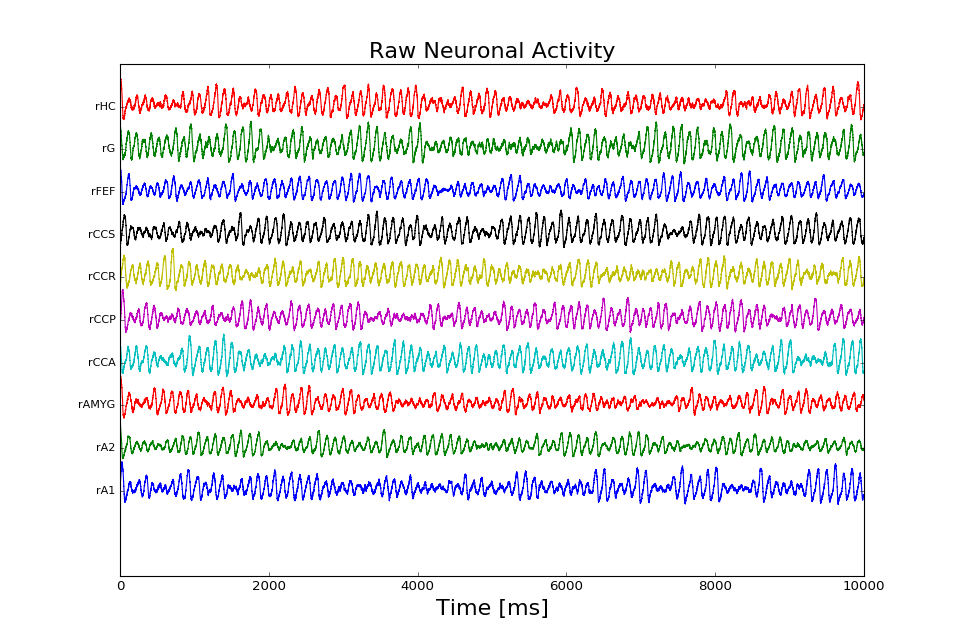

<IPython.core.display.Javascript object>


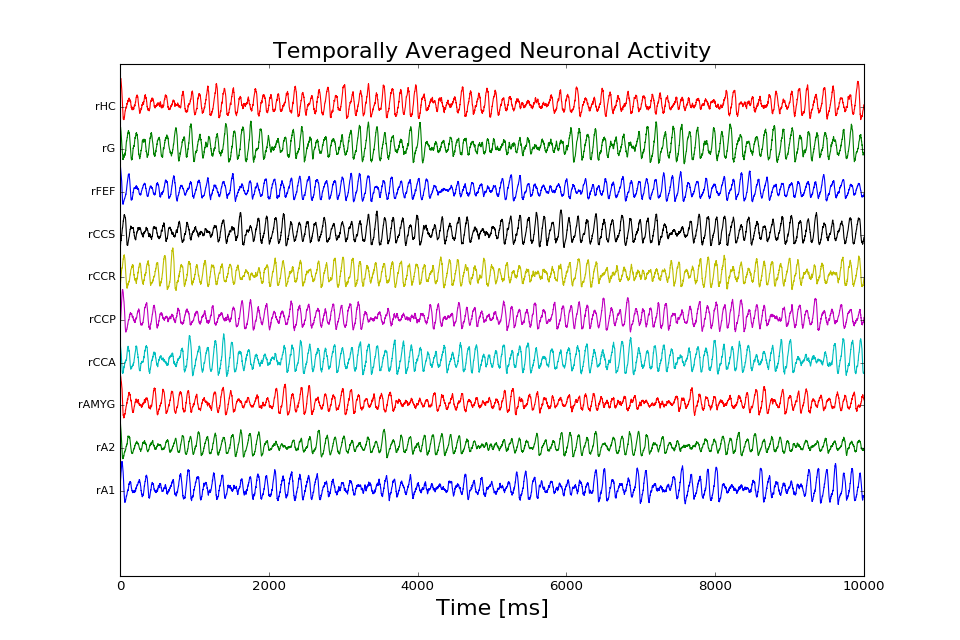

In [11]:
# Plot the raw time series 
fig1 = plt.figure(figsize=(12,8))
plt.plot(raw_time[:], RAW[:, :10] + r_[:10])
plt.title('Raw Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(10), TVB_con.region_labels, fontsize=10)

# Plot the temporally averaged time series
fig2 = plt.figure(figsize=(12,8))
plt.plot(tavg_time[:], TAVG[:, :10] + r_[:10])
plt.title('Temporally Averaged Neuronal Activity', fontsize=20)
plt.xlabel('Time [ms]', fontsize=20)
plt.yticks(range(10), TVB_con.region_labels, fontsize=10)

plt.show()

<h1><font size="6" face="arial" color="black">2. Exploring a Model</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The second part of this tutorial presents the exploration of the dynamics of a <b>Model</b> object, and at the same time, set its parameters, using the <b>phase_plane_interactive</b> plotting tool .</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Note that this works best for the simpler, 2d, models, as their trajectories and nullclines lie within a single plane and are thus easily visualised. And so, for the demo here we will stick with a model of that type. However, although it requires a little more effort, it can still be used to get a basic handle on the dynamics of higher dimensional models.</font></div></p>


<p><div style="text-align: justify"><font size="4.5" face="time roman">It is also important to note that this is only for the <b>local dynamic model</b>, that is, it only represents the dynamic behaviour of a <b>disconnected</b> node.</font></div></p>

- ## <font size="5"face="arial" color="black">Create an interactive phase-plane</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman"><b>PhasePlaneInteractive</b> produces an interactive window containing plots of a Model's phase-plane, sample trajectories, and sliders and buttons for adjusting various parameters.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We will begin by creating a <b>Model</b> object and taking a quick look at its parameters. Here we will explore the model previously introduce:</font></div></p>

In [12]:
# Initialise a Model.
g2d = models.Generic2dOscillator()
g2d

Generic2dOscillator(bound=False, value=None)

In [17]:
# Initialise an Integrator scheme.
dt = 1    #integration steps [ms]
heunint = integrators.HeunDeterministic(dt=dt)

<p><div style="text-align: justify"><font size="4.5" face="time roman">We will now create and launch the interactive plot:</font></div></p>

<IPython.core.display.Javascript object>


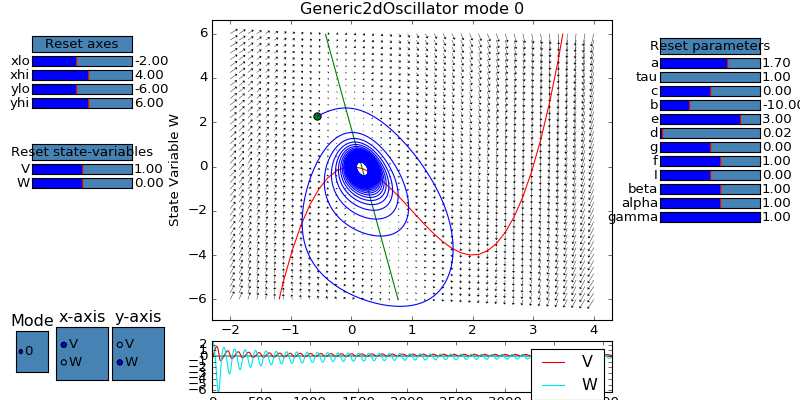

In [18]:
# Create and lunch the phase-plane tool.
ppi_fig = PhasePlaneInteractive(model=g2d, integrator=heunint)
ppi_fig.show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">In the main central panel of the window, you can see the phase-plane for the model, including arrows representing the vector field and coloured lines representing any nullclines present in this plane. Clicking on the phase-plane will launch a sample trajectory originating from where you clicked. Below the phase-plane is a panel which will show time-series for all state variables for any sample trajectories you initiate. All around the edges are sliders for adjusting model parameters and adjusting what is displayed. The red vertical lines in sliders indicate the initial values.</font></div></p>

<br></br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">After we have adjusted parameters to our satisfaction, we can close the window and take another quick look at the parameters of our model:
</font></div></p>

In [87]:
g2d

Generic2dOscillator(bound=False, value=None)

<p><div style="text-align: justify"><font size="4.5" face="time roman">As you can see in the lines above, the model's parameters, for example $a$, $tau$, and the <i>state_variable_ranges</i> are modified from their initial values.</font></div></p>

- ## <font size="5"face="arial" color="black">Using a stochastic integration scheme</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">It is possible to explicitly specify the integration scheme used to plot sample trajectories. This can be useful when deciding what amplitude to give your noise when specifying a stochastic integration scheme.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We will take a look at this using <b>HeunStochastic</b>, we will also pass in the same Model object we modified above. In this way, PhasePlaneInteractive initialises with the parameters we would set for the Model, so that here we can focus on the effect of the noise amplitude relative to the intrinsic dynamics.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Starting by setting the noise to 0.0, to get a deterministic trajectory, and then adding a small amount of noise can help give a useful intuition for the effects of noise on a simulation.</font></div></p>

In [19]:
# Initialise an Integrator scheme.
dt = 1                                           #integration steps [ms]
heunstochint = integrators.HeunStochastic(dt=dt)
heunstochint.noise.nsig = 0.001                  #standard deviation of the noise 

<IPython.core.display.Javascript object>


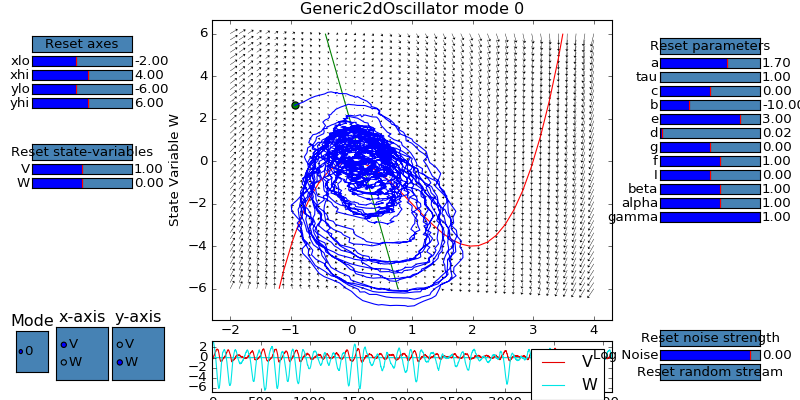

In [20]:
ppi_fig = PhasePlaneInteractive(model=g2d, integrator=heunstochint)
ppi_fig.show()

<h1><font size="6"face="arial" color="black"> 2. Analyse our simulation</font></h1>

## <font size="5" face="arial" color="black"> 2.1 Functional Connectivity (FC)</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman"><b>Functional Connectivity (FC)</b> describes the connectedness of two brain regions by means of the covariance between their time series. The classic and most widely used method to infer the strength of network interactions or functional connections consists in estimating the linear (Pearson) correlation coefficient between temporal signals. If two regions activate and deactivate at the same time, there is likely a functional connection. The Pearson correlation coefficient between two series $X$ and $Y$ of size $N$ is given by the following equation:</font></div></p> 

\begin{eqnarray}
    Corr(X, Y) = \dfrac{\sum_{n=1}^{N}(X_{n} - \bar{X})(Y_{n} - \bar{Y})}{\sqrt{\sum_{n=1}^{N}(X_{n} - \bar{X})^2}\sqrt{\sum_{n=1}^{N}(Y_{n} - \bar{Y})^2}}
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">To this end, we will show how to build a <b>Region Time Series</b> object from our simulated data, and then apply a <b>Time Series Analyzer</b>, <i>corrcoef</i> in this case, to the time series, resulting in FC.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">So first, for the analyzer, we build a time series object:</font></div></p>

In [21]:
# Discarded first seconds to avoid initial transient dynamics.
tavg_data = tavg_data[1000:10000]

# Build a TimeSeries Dataype.
tsr = TimeSeriesRegion(connectivity=TVB_con,
                       data=tavg_data, 
                       sample_period=sim.monitors[1].period)
tsr.configure()

<p><div style="text-align: justify"><font size="4.5" face="time roman">and create and evaluate the analysis:</font></div></p>

In [22]:
# Compute FC.
corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
corrcoeff_data = corrcoeff_analyser.evaluate()
corrcoeff_data.configure()
FC = corrcoeff_data.array_data[..., 0, 0]

   INFO  result shape will be: (76, 76, 1, 1)


<p><div style="text-align: justify"><font size="4.5" face="time roman">and display the resulting FC matrix:</font></div></p>

<IPython.core.display.Javascript object>


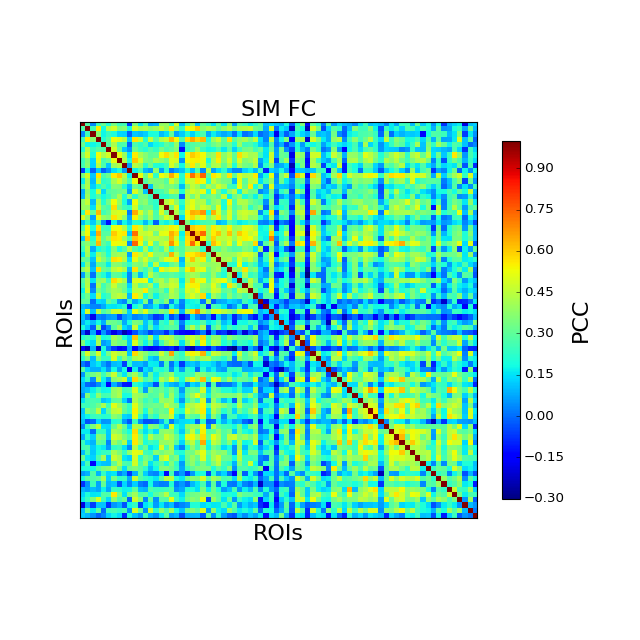

In [23]:
# Visualize FC matrix
plt.figure(figsize=(8,8))
plt.imshow(FC, interpolation='nearest', cmap='jet')
plt.title('SIM FC', fontsize=20)
plt.xlabel('ROIs', fontsize=20); plt.ylabel('ROIs', fontsize=20)
plt.xticks([], fontsize=20); plt.yticks([], fontsize=20)
cb = plt.colorbar(shrink=0.7)
cb.set_label('PCC', fontsize=20)

plt.show()

- ## <font size="5"face="arial" color="black"> SC - FC comparison</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We compare the empirical SC and simulated FC matrix by adopting as a measure of similarity between the two matrices the Pearson correlation between corresponding elements of the <b>upper (or lower)</b> triangular part of the matrices.</font></div></p>

In [24]:
# Take upper triangular part of the matrices (excluding the self-connections).
TVB_SC_triu = np.triu(TVB_SC, 1)
FC_triu = np.triu(FC, 1)

# Compute Pearson correlation coefficients between SC and FC.
pcc = np.corrcoef(TVB_SC_triu.ravel(), FC_triu.ravel())[0, 1]
pcc

0.51109835234320566

## <font size="5" face="arial" color="black"> 2.2 Extract Resting-State Networks (RSNs)</font>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> We will next study in more detail which features of the FC are explained by the model. For this, we will concentrate on seed-based correlation and principal components of the simulated FC.</font></div></p>

- ## <font size="5"face="arial" color="black">Seed-region correlation maps</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A common visualization of FC specific to a given brain region is to pull out its row of the FC matrix and plot a colormap on the anatomy. We can do this with the simulated functional connectivity to identify which regions are highly coordinated with the seed region.</font></div></p>

In [28]:
def plot_roi_corr_map(reg_name):
    roi = find(TVB_con.ordered_labels==reg_name)[0]
    cs_m = FC
    rm = utils.cortex.region_mapping
    utils.multiview(cs_m[roi][rm], shaded=False, suptitle=reg_name, figsize=(10, 5))

<p><div style="text-align: justify"><font size="4.5" face="time roman">As a few examples of such maps, we take the medial parietal cortex as seed which take part of the well-known default-mode network (RSN1), as well as the middle prefrontal cortex for the dorsal attentional network (RSN2), the primary visual cortex for the visual network (RSN3), and the superior temporal cortex for the auditory network (RSN4). The seed regions use here are all in the right hemisphere.</font></div></p>

<IPython.core.display.Javascript object>


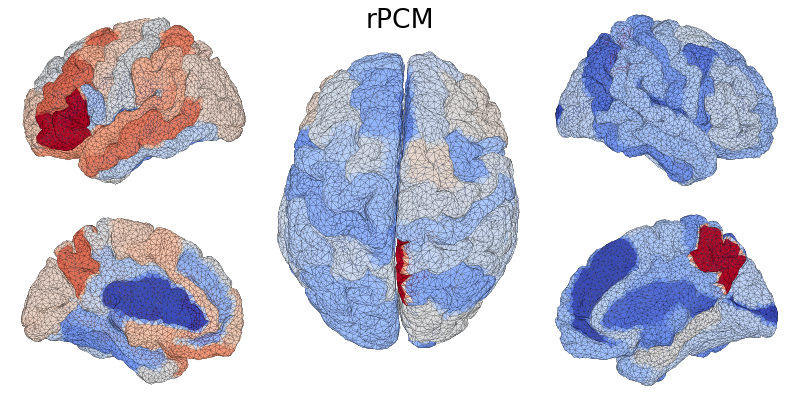

<IPython.core.display.Javascript object>


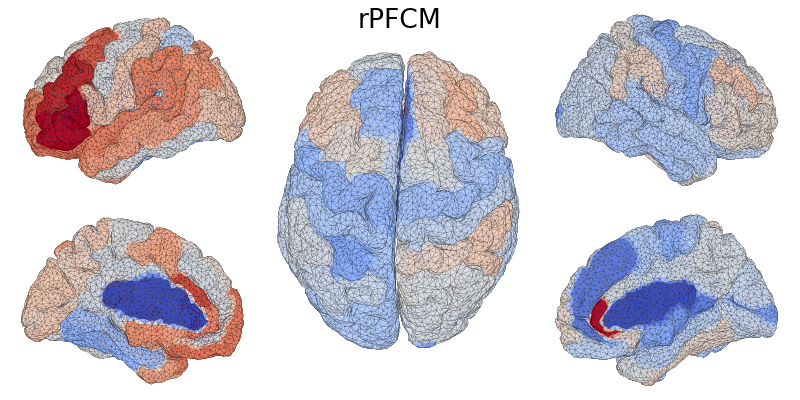

<IPython.core.display.Javascript object>


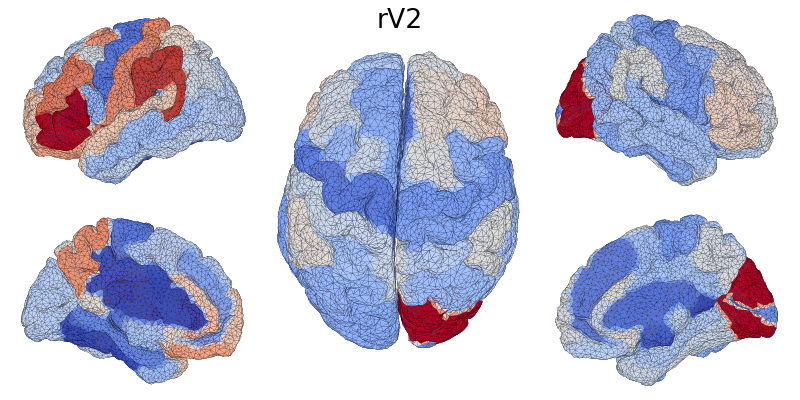

<IPython.core.display.Javascript object>


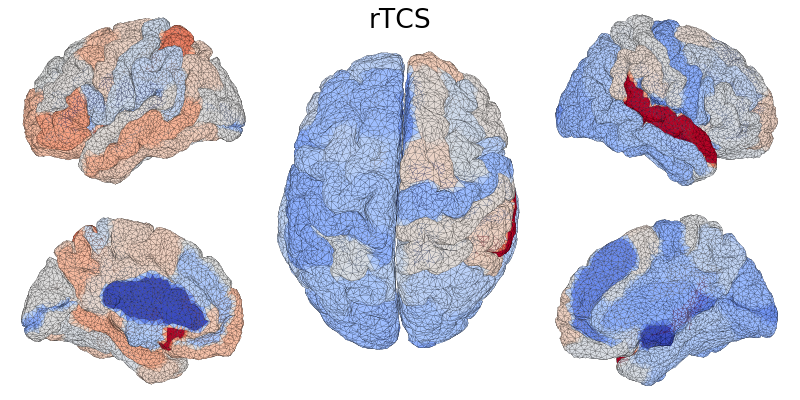

In [32]:
for reg in 'rPCM rPFCM rV2 rTCS'.split():
    plot_roi_corr_map(reg)

- ## <font size="5"face="arial" color="black">Independent Component Analysis (ICA)</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Another common exploratory tool in resting-state data analysis, where the implicated regions or networks are not known a priori, is <b>Independent Component Analysis</b>, which extracts components with unique or independent statistical properties.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">For example, we can perform an ICA keeping 3 components from the above simulated data:</font></div></p>

In [33]:
ica = FastICA(n_components=5, max_iter=250)
ica.fit(FC_triu)

/Applications/TVB_Distribution/tvb.app/Contents/Resources/lib/python2.7/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=250,
    n_components=5, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

<p><div style="text-align: justify"><font size="4.5" face="time roman">And then, visualize the different components:</font></div></p>

<IPython.core.display.Javascript object>


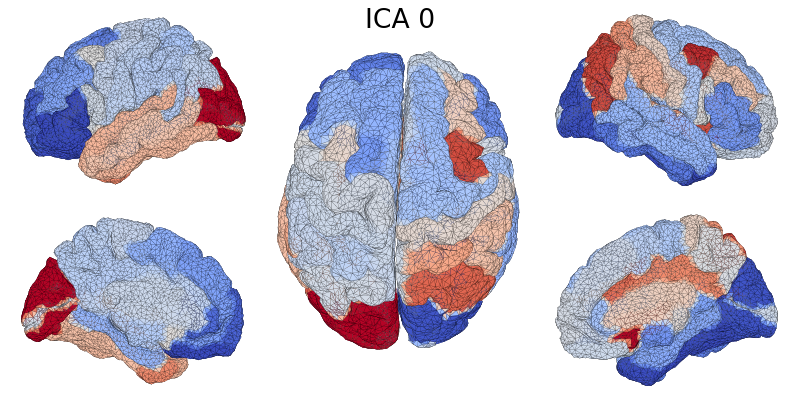

<IPython.core.display.Javascript object>


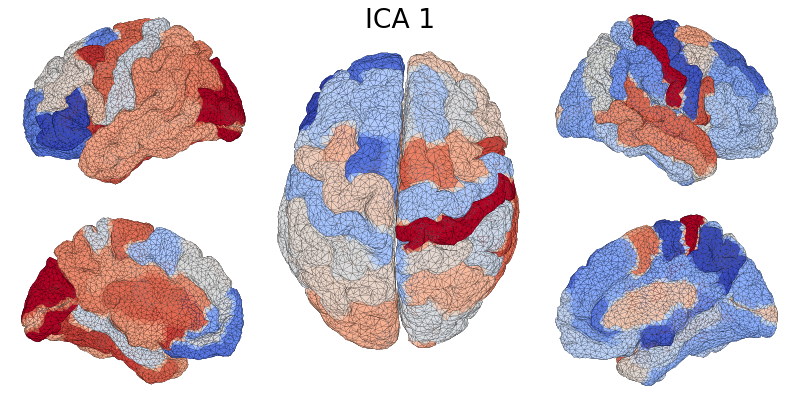

<IPython.core.display.Javascript object>


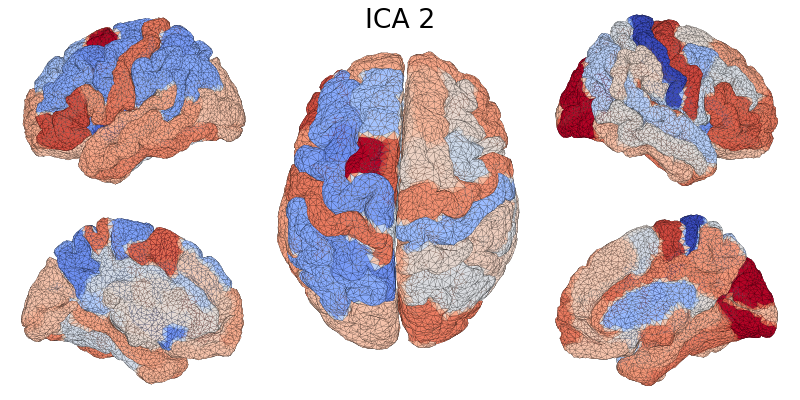

In [34]:
for i, comp in enumerate(ica.components_[:3]):
    utils.multiview(comp[utils.cortex.region_mapping], shaded=False, 
                    suptitle='ICA %d' % (i, ), figsize=(10, 5))

<p><div style="text-align: justify"><font size="4.5" face="time roman">These components are not selected 'by hand', but represent independent subnetworks during the simulated resting state activity.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Finally, we point out, that commonly ICA analyses of fMRI are done at a group level to identify spatial patterns which are reproducible across subjects, whereas in this application to this simulation, spatial components may reflect as much non-robust, spontaneous fluctuations of the network passing through various state as the dominant rest state networks identified in human rest state.</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">That is all folks -- so, what now?</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">And that is it for this tutorial. These results are starting point, from which we can base our next simulations, going in directions such as:

<br></br>
<ul>
<li>using our own connectivity data in TVB's scripting interface,</li>
<li>perform a parameter sweep to identify regions of improved empirical and model FC correlations</li>
<li>etc.</li>
</ul>
</font></div></p>

<br></br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">We hope this has been a useful tutorial and welcome any comments or questions.</font></div></p>